In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import plotly.express as px
import osmnx as ox
import networkx as nx
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2
# from osmnx. import plot_graph_route_folium


In [2]:
import osmnx as ox
print(ox.__version__)


2.0.4


In [3]:
city = "Dubai"
dtf=pd.read_csv('data_stores.csv')
dtf=dtf[dtf["City"]==city][ ["City", "Street Address", "Latitude", "Longitude"]].reset_index(drop=True)
dtf=dtf.reset_index().rename(columns={"index":"id", "Latitude":"y", "Longitude":"x"})

print("total", len(dtf))
dtf.head(3)

total 78


,id,City,Street Address,y,x
0,0,Dubai,"Jumeirah, Near Spinney's",25.17,55.23
1,1,Dubai,"Reel Cinema, Dubai Mall, Second Floor",24.78,55.60
2,2,Dubai,"Dubai Airport Rd, Terminal 3",25.25,55.35


In [4]:
data = dtf.copy()
data["color"]=''
data.loc[data['id']==0 , 'color'] = 'red'
data.loc[data['id']!=0 , 'color'] = 'black'
start=data[data["id"]==0][["y","x"]].values[0]
data.head(3)
print("starting point:" , start)

starting point: [25.17 55.23]


In [5]:
map = folium.Map(location=start, tiles="CartoDB positron", zoom_start=12)

data.apply(lambda row:
    folium.CircleMarker(
        location=[row["y"], row["x"]],
        color=row["color"], fill = True, radius=5).add_to(map), axis=1)

map

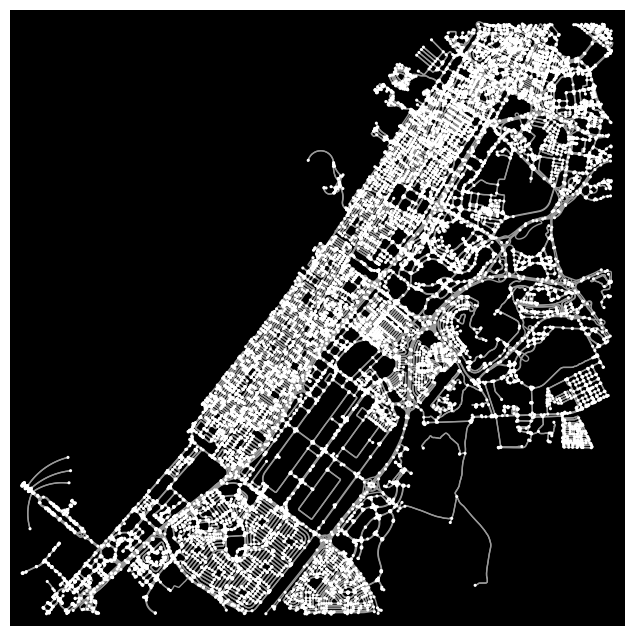

In [6]:
G=ox.graph_from_point(start, dist=10000, network_type="drive")
G=ox.add_edge_speeds(G)
G=ox.add_edge_travel_times(G)
fig,ax = ox.plot_graph(G, bgcolor="black", node_size=5, node_color="white", figsize=(16,8))

In [7]:

start_node=ox.distance.nearest_nodes(G, start[1], start[0])
dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
dtf=dtf.drop_duplicates("node", keep='first')
dtf.head()

C:\Users\Dell-Laptop\AppData\Local\Temp\ipykernel_26940\541981123.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
C:\Users\Dell-Laptop\AppData\Local\Temp\ipykernel_26940\541981123.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
C:\Users\Dell-Laptop\AppData\Local\Temp\ipykernel_26940\541981123.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tre

,id,City,Street Address,y,x,node
0,0,Dubai,"Jumeirah, Near Spinney's",25.17,55.23,9909543566
1,1,Dubai,"Reel Cinema, Dubai Mall, Second Floor",24.78,55.60,3144027321
2,2,Dubai,"Dubai Airport Rd, Terminal 3",25.25,55.35,9442276073
3,3,Dubai,"Safa Street, Jumeirah 1, Jumeirah District",25.27,55.31,92597839
4,4,Dubai,DIFC Building No. 5,25.10,55.16,1013759018


In [8]:
def f(a, b):
    try:
        d=nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        d=np.nan
    return d
distance_matrix = np.asarray([[f(a, b)for b in dtf["node"].tolist()]for a in dtf["node"].tolist()])
distance_matrix = pd.DataFrame(distance_matrix, columns=dtf["node"].values, index=dtf["node"].values)

distance_matrix.head()

,9909543566,3144027321,9442276073,92597839,1013759018,5801901656,8767367535,1013754446,1896164548,4966337053,...,12906025354,12551231123,1037159037,10020768212,1015816739,2163716894,1013700196,4904279768,1049694340,1141331254
9909543566,0.000000,1120.859088,737.096791,NaN,607.281040,395.149860,486.774944,NaN,481.546176,744.798443,...,543.057501,902.970404,495.108055,441.977591,566.181858,655.352099,602.241112,684.694250,653.253686,NaN
3144027321,1068.529945,0.000000,1446.013231,NaN,1435.760954,1173.928185,1218.389703,NaN,1255.553783,1353.041448,...,1422.020637,963.122863,1438.432282,1385.301818,1345.002412,1377.759496,1430.721025,1463.514805,1234.756088,NaN
9442276073,697.003742,1434.516985,0.000000,NaN,1069.652032,642.856518,430.587086,NaN,943.917167,179.629591,...,350.016046,1091.099323,506.208818,461.188483,328.365398,427.883593,1064.612103,255.249779,1115.624677,NaN
92597839,643.637888,1452.755188,240.904089,0.0,1016.286177,594.457364,373.701395,NaN,890.551313,292.890105,...,223.694539,1109.337527,395.806457,359.779177,274.999544,385.710724,1011.246248,128.928271,1062.258823,NaN
1013759018,696.389656,1348.138902,1178.872006,NaN,0.000000,836.925076,928.550160,NaN,481.807481,1186.573659,...,1084.975298,1354.681280,1073.876006,1062.225051,1007.957073,1097.127315,214.151002,1126.469466,571.967742,NaN


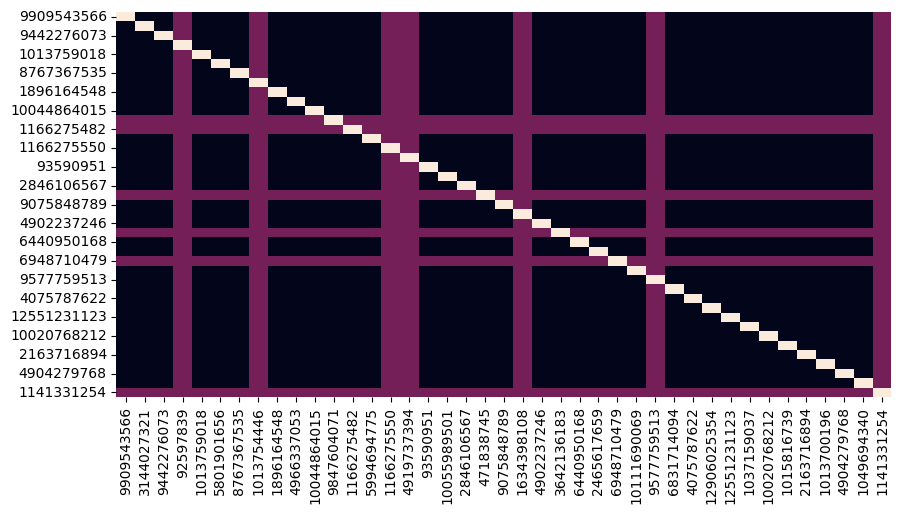

In [9]:
heatmap = distance_matrix.copy()
for col in heatmap.columns:
    heatmap[col]=heatmap[col].apply(lambda x:
        0.3 if pd.isnull(x) else
        (0.7 if np.isinf(x) else
         (0 if x!=0 else 1)))
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(heatmap, vmin=0, vmax=1, cbar=False, ax=ax)
plt.show()

In [10]:
distance_matrix =  distance_matrix.round()
distance_matrix.replace([np.nan, np.inf], 999999, inplace=True)
distance_matrix = distance_matrix.astype('int')
distance_matrix

,9909543566,3144027321,9442276073,92597839,1013759018,5801901656,8767367535,1013754446,1896164548,4966337053,...,12906025354,12551231123,1037159037,10020768212,1015816739,2163716894,1013700196,4904279768,1049694340,1141331254
9909543566,0,1121,737,999999,607,395,487,999999,482,745,...,543,903,495,442,566,655,602,685,653,999999
3144027321,1069,0,1446,999999,1436,1174,1218,999999,1256,1353,...,1422,963,1438,1385,1345,1378,1431,1464,1235,999999
9442276073,697,1435,0,999999,1070,643,431,999999,944,180,...,350,1091,506,461,328,428,1065,255,1116,999999
92597839,644,1453,241,0,1016,594,374,999999,891,293,...,224,1109,396,360,275,386,1011,129,1062,999999
1013759018,696,1348,1179,999999,0,837,929,999999,482,1187,...,1085,1355,1074,1062,1008,1097,214,1126,572,999999
5801901656,435,1150,551,999999,808,0,217,999999,682,559,...,457,866,483,427,380,464,803,499,849,999999
8767367535,422,1221,424,999999,795,221,0,999999,669,431,...,309,958,386,333,232,295,790,351,841,999999
1013754446,686,1338,1169,999999,241,827,918,0,472,1176,...,1075,1344,1108,1052,998,1087,206,1116,645,999999
1896164548,494,1020,977,999999,461,635,727,999999,0,985,...,883,1025,917,860,806,895,456,925,336,999999
4966337053,715,1345,180,999999,1087,554,407,999999,961,0,...,311,1002,483,447,346,346,1082,313,1055,999999


In [11]:
drivers = 1
lst_nodes = dtf["node"].tolist()
print("start: ", start_node, ", total locations to visit: ", len(lst_nodes)-1, ", drivers: ", drivers)


start:  9909543566 , total locations to visit:  40 , drivers:  1


In [12]:
manager = pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, lst_nodes.index(start_node))
model = pywrapcp.RoutingModel(manager)

In [13]:
def get_distance(from_index, to_index):
    return distance_matrix.iloc[from_index, to_index]

distance = model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

In [14]:
solution=model.SolveWithParameters(parameters)
index = model.Start(0)
print('route for drivers: ')
route_idx, route_distance = [], 0

while not model.IsEnd(index):
    route_idx.append(manager.IndexToNode(index))
    previous_index = index
    index=solution.Value(model.NextVar(index))
    
    try:
        route_distance += get_distance(previous_index, index)
    except:
        route_distance+= model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=0)

print(route_idx)
print(f'Total distance: {round(route_distance/1000, 2)}KM')
print(f'Nodes visited: {len(route_idx)}')

route for drivers: 
[0, 24, 16, 17, 33, 34, 31, 27, 35, 25, 30, 9, 26, 40, 39, 8, 22, 18, 4, 37, 12, 38, 2, 19, 36, 6, 20, 5, 10, 13, 29, 23, 32, 1, 11, 28, 21, 15, 14, 7, 3]
Total distance: 11009.12KM
Nodes visited: 41


In [15]:
print("Route for driver (nodes): ")
lst_route = [lst_nodes[i] for i in route_idx]
print(lst_route)

Route for driver (nodes): 
[9909543566, 6440950168, 93590951, 10055989501, 1037159037, 10020768212, 12906025354, 10111690069, 1015816739, 2465617659, 4075787622, 4966337053, 6948710479, 1141331254, 1049694340, 1896164548, 4902237246, 2846106567, 1013759018, 1013700196, 1166275482, 4904279768, 9442276073, 471838745, 2163716894, 8767367535, 9075848789, 5801901656, 10044864015, 5994694775, 6831714094, 3642136183, 12551231123, 3144027321, 9847604071, 9577759513, 1634398108, 4919737394, 1166275550, 1013754446, 92597839]


In [16]:
def get_path_between_nodes(lst_route):
    lst_paths=[]
    for i in range (len(lst_route)):
        try :
            a , b = lst_nodes[i], lst_nodes[i+1]
        except:
            break
        try:
            path=nx.shortest_path(G, source=a, target=b, method ='dijkstra', weight='travel_time')
            if len(path) > 1:
                lst_paths.append(path)
        except:
            continue
    return lst_paths

lst_paths= get_path_between_nodes(lst_route)

for path in lst_paths:
    route_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in path]
    folium.PolyLine(route_coords, color="blue", weight=2, opacity=0.8).add_to(map)
    
map

In [17]:

def df_animation_multiple_path(G, lst_paths, parallel=True):
    df=pd.DataFrame()
    for path in lst_paths :
        lst_start, lst_end = [] , []
        start_x, start_y = [] , []
        end_x, end_y = [], []
        lst_length, lst_time = [], [] 
        
        for a , b in zip (path[:-1], path[1:]):
            lst_start.append(a)
            lst_end.append(b)
            lst_length.append(round(G.edges[(a,b,0)]['length']))
            lst_time.append(round(G.edges[(a,b,0)]['travel_time']))
            start_x.append(G.nodes[a]['x'])
            start_y.append(G.nodes[a]['y'])
            end_x.append(G.nodes[b]['x'])
            end_y.append(G.nodes[b]['y'])
            
        tmp=pd.DataFrame(list(zip(lst_start, lst_end, start_x, start_y, end_x, end_y, lst_length, lst_time)), 
                         columns= ["start", "end", "start_x", "start_y", "end_x", "end_y", "length", "travel_time"])
        df=pd.concat([df,tmp], ignore_index=(not parallel))
        
    df=df.reset_index().rename(columns={"index":"id"})
    return df
            

In [18]:
df = pd.DataFrame()
tmp = df_animation_multiple_path(G, lst_paths, parallel=False)
df=pd.concat([df, tmp], axis=0)
first_node, last_node = lst_paths[0][0], lst_paths[-1][-1]


In [19]:
df_start = df[df["start"]==first_node]
df_end = df[df["end"]==last_node]
# Skip every N frames to speed it up
df = df[df["id"] % 5 == 0]  # keeps every 5th step

fig=px.scatter_mapbox(data_frame=df, lon="start_x", lat = "start_y", zoom=15, width=900, height=700, animation_frame="id", mapbox_style="carto-positron")
fig.data[0].marker={"size":12}

fig.add_trace(px.scatter_mapbox(data_frame=dtf, lon="x", lat="y").data[0])
fig.data[1].marker={"size":10, "color":"black"}

fig.add_trace(px.scatter_mapbox(data_frame=df_start, lon="start_x", lat="start_y").data[0])
fig.data[2].marker={"size":15, "color":"red"}

fig.add_trace(px.scatter_mapbox(data_frame=df_end, lon="start_x", lat="start_y").data[0])
fig.data[3].marker={"size":15, "color":"green"}

fig.add_trace(px.line_mapbox(data_frame=df, lon="start_x", lat="start_y").data[0])
fig

C:\Users\Dell-Laptop\AppData\Local\Temp\ipykernel_26940\3722421428.py:6: DeprecationWarning: *scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  fig=px.scatter_mapbox(data_frame=df, lon="start_x", lat = "start_y", zoom=15, width=900, height=700, animation_frame="id", mapbox_style="carto-positron")
C:\Users\Dell-Laptop\AppData\Local\Temp\ipykernel_26940\3722421428.py:9: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

C:\Users\Dell-Laptop\AppData\Local\Temp\ipykernel_26940\3722421428.py:12: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

C:\Users\Dell-Laptop\AppData\Local\Temp\ipykernel_26940\3722421428.py:15: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbo

In [20]:
# Total distance in meters
total_distance_m = df["length"].sum()

# Convert to kilometers
total_distance_km = total_distance_m / 1000

# Assume average mileage (in km/l)
average_mileage = 12  # You can customize this

# Estimate fuel used
fuel_used_liters = total_distance_km / average_mileage

print(f"Total distance: {round(total_distance_km, 2)} km")
print(f"Estimated fuel consumption: {round(fuel_used_liters, 2)} liters (at {average_mileage} km/l)")


Total distance: 81.03 km
Estimated fuel consumption: 6.75 liters (at 12 km/l)
